### plot feature kernels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import wasserstein_distance

import sys
sys.path.append('../')
from expt_configs import old_configs, bs_dict, parameterization_dict, dashes_dict

print(f"keys available: {old_configs.keys()}")

keys available: dict_keys(['cartpole', 'panda', 'humanoid'])


In [2]:
# choose experiment data
config_name = 'panda'
plot_dir = "figs"

In [3]:
config = old_configs[config_name]
num_seeds = config['num_seeds']
env_name = config['env_name']
layer_sizes = config['layer_sizes']
timesteps = config['timesteps']
file_anal = config['end_dir']
temporal_anal = config['temporal_dir']
N_keys_corresponding_idxs = {4: 0, 8: 1, 16: 2, 32: 3, 48: 4, 64: 5, 128: 6, 256: 7, 512: 8, 1024: 9}
name_list = ['Initial', 'NTK', '$\mu P$']

os.makedirs(plot_dir, exist_ok=True)
fig_dir = os.path.join(plot_dir, config_name)
os.makedirs(fig_dir, exist_ok=True)
print(f"Made directory {fig_dir}")

Made directory figs/panda


In [4]:

# load the file
data = np.load(file_anal, allow_pickle=True)
feature_layers_dict_loaded = data["feature_layers_dict"].item()
hdensity_loaded = data["hdensity"]
# # entropys_loaded = data["entropys"] 
# logits_loaded = data["logits"]
# # scales_loaded = data["scales"]
# # value_feature_layers_dict_loaded = data["value_feature_layers_dict"].item()
# # value_preds_loaded = data["value_preds"]
# # policy_actions_loaded = data["policy_actions"]

# # Get temporal data
# temporal_data = np.load(temporal_anal, allow_pickle=True)
# temporal_feature_layers_dict_loaded = temporal_data["feature_layers_time_dict"].item()
# temporal_hdensity_loaded = temporal_data["hdensity_time"]
# temporal_entropys_loaded = temporal_data["entropys_time"]
# temporal_logits_loaded = temporal_data["logits_time"] 
# temporal_scales_loaded = temporal_data["scales_time"]
# temporal_value_feature_layers_dict = temporal_data["value_feature_layers_time_dict"].item()
# temporal_value_preds = temporal_data["value_preds_time"]
# temporal_policy_actions_loaded = temporal_data["policy_actions_time"]

# print(temporal_feature_layers_dict_loaded.keys())
# # print(f"Temporal shapes: feature_layers={temporal_feature_layers_dict_loaded[4].shape}, hdensity={temporal_hdensity_loaded.shape}, entropys={temporal_entropys_loaded.shape}, logits={temporal_logits_loaded.shape}, scales={temporal_scales_loaded.shape}, value_feature_layers={temporal_value_feature_layers_dict[4].shape}, value_preds={temporal_value_preds.shape}, policy_actions={temporal_policy_actions_loaded.shape}")
# print(f"Temporal shapes: feature_layers={temporal_feature_layers_dict_loaded[4].shape}, hdensity={temporal_hdensity_loaded.shape}, entropys={temporal_entropys_loaded.shape}, logits={temporal_logits_loaded.shape}, scales={temporal_scales_loaded.shape}, value_feature_layers={temporal_value_feature_layers_dict[4].shape}, value_preds={temporal_value_preds.shape}")

### Analyze random features

Key: 4, Value: (3, 5, 858, 4)
Key: 16, Value: (3, 5, 858, 16)
Key: 64, Value: (3, 5, 858, 64)
Key: 256, Value: (3, 5, 858, 256)
Seed Correlation across widths: [0.1058532  0.50376835 0.81610055 0.94907998]


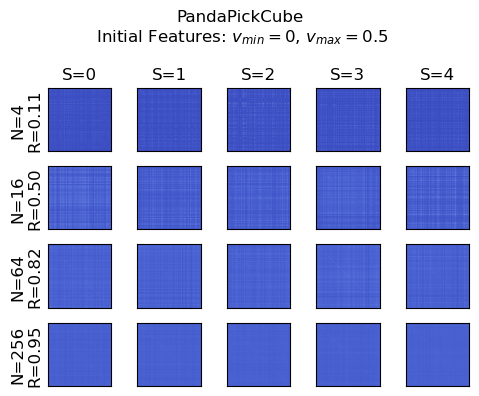

In [5]:
scaling = 0 # 0: initial, 1: NTK, 2: muP

name = name_list[scaling]

N_to_plot = [4, 16, 64, 256]
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 0.5
l = 0
f.suptitle(f"{env_name}\n {name} Features: $v_{{min}}=0$, $v_{{max}}={vmax}$")

feat_sim = np.zeros(len(N_to_plot))
H = []
Hx = []
# feats = np.zeros([5, logits_loaded.shape[-2], logits_loaded.shape[-2]])

for key, feat in feature_layers_dict_loaded.items():
    if key not in N_to_plot:
        continue
    print(f"Key: {key}, Value: {feat.shape}")

    storex = []
    store = []
    for s in range(5):
        x = feat[scaling, s]
        k = x@x.T / key
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        store.append(x)
        ax[0,s].set_title(f"S={s}",fontsize=12)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    feat_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


    ax[l, 0].set_ylabel(f"N={key}\nR={feat_sim[l]:.2f}", fontsize=12)
    H.append(storex)
    Hx.append(store)
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/feature_seed_{name}_{env_name}_vmax{vmax}.pdf",bbox_inches='tight')
print("Seed Correlation across widths:", feat_sim)


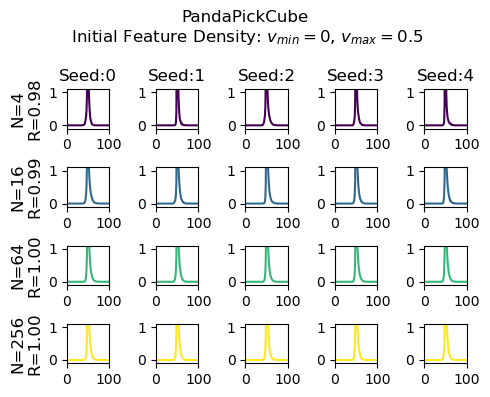

In [6]:
# get individual colors from viridis

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(N_to_plot)-1)) for i in range(len(N_to_plot))]

density_sim = np.zeros(len(N_to_plot))
f,ax = plt.subplots(len(N_to_plot),num_seeds, figsize=(1*num_seeds, 1*len(N_to_plot)))
f.suptitle(f"{env_name}\n {name} Feature Density: $v_{{min}}=0$, $v_{{max}}={vmax}$")

for i,N in enumerate(N_to_plot):
    n =  N_keys_corresponding_idxs[N]

    storeh = []
    for s in range(num_seeds):

        h = hdensity_loaded[scaling, n, s]
        ax[i,s].plot(h, color=colors[i])
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        storeh.append(h.reshape(1,-1))
        ax[i,s].set_xlim([0, h.shape[0]])
        ax[i,s].set_ylim([-0.1, 1.1])
    
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    density_sim[i] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[i, 0].set_ylabel(f"N={N}\nR={density_sim[i]:.2f}", fontsize=12)

f.tight_layout()

### Analyze NTK features

Key: 4, Value: (3, 5, 858, 4)
Key: 16, Value: (3, 5, 858, 16)
Key: 64, Value: (3, 5, 858, 64)
Key: 256, Value: (3, 5, 858, 256)
[0.04189409 0.46120722 0.60394657 0.82185472]


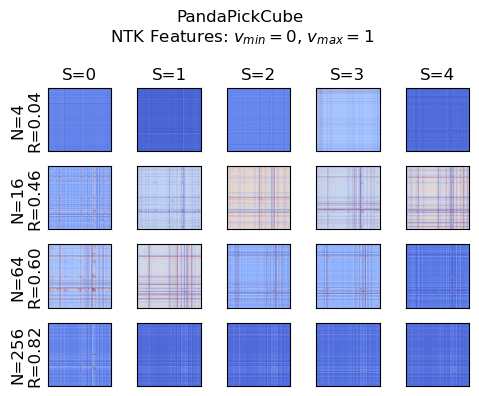

In [7]:
scaling = 1 # 0: initial, 1: NTK, 2: muP

name = name_list[scaling]

N_to_plot = [4, 16, 64, 256]
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 1
l = 0
f.suptitle(f"{env_name}\n {name} Features: $v_{{min}}=0$, $v_{{max}}={vmax}$")

feat_sim = np.zeros(len(N_to_plot))
H = []
Hx = []
# feats = np.zeros([5, logits_loaded.shape[-2], logits_loaded.shape[-2]])

for key, feat in feature_layers_dict_loaded.items():
    if key not in N_to_plot:
        continue
    print(f"Key: {key}, Value: {feat.shape}")

    storex = []
    store = []
    for s in range(5):
        x = feat[scaling, s]
        k = x@x.T / key
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        store.append(x)
        ax[0,s].set_title(f"S={s}",fontsize=12)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    feat_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


    ax[l, 0].set_ylabel(f"N={key}\nR={feat_sim[l]:.2f}", fontsize=12)
    H.append(storex)
    Hx.append(store)
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/feature_seed_{name}_{env_name}_vmax{vmax}.pdf",bbox_inches='tight')
print(feat_sim)


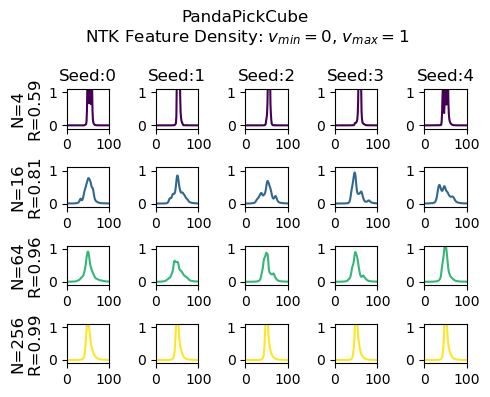

In [8]:
# get individual colors from viridis

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(N_to_plot)-1)) for i in range(len(N_to_plot))]

density_sim = np.zeros(len(N_to_plot))
f,ax = plt.subplots(len(N_to_plot),num_seeds, figsize=(1*num_seeds, 1*len(N_to_plot)))
f.suptitle(f"{env_name}\n {name} Feature Density: $v_{{min}}=0$, $v_{{max}}={vmax}$")
for i,N in enumerate(N_to_plot):
    n =  N_keys_corresponding_idxs[N]

    storeh = []
    for s in range(num_seeds):

        h = hdensity_loaded[scaling, n, s]
        ax[i,s].plot(h, color=colors[i])
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        storeh.append(h.reshape(1,-1))
        ax[i,s].set_xlim([0, h.shape[0]])
        ax[i,s].set_ylim([-0.1, 1.1])
    
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    density_sim[i] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[i, 0].set_ylabel(f"N={N}\nR={density_sim[i]:.2f}", fontsize=12)

f.tight_layout()

### Analyze muP Features

Key: 4, Value: (3, 5, 858, 4)
Key: 16, Value: (3, 5, 858, 16)
Key: 64, Value: (3, 5, 858, 64)
Key: 256, Value: (3, 5, 858, 256)
[0.10888177 0.30535108 0.77271896 0.93816454]


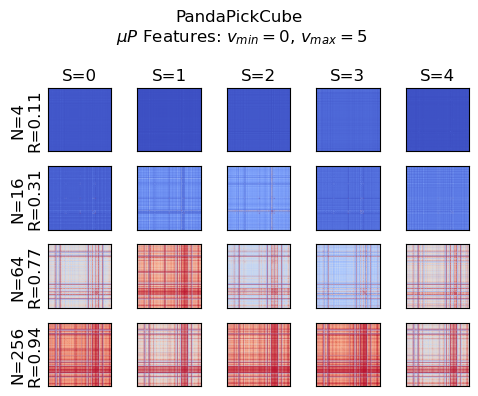

In [9]:
scaling = 2 # 0: initial, 1: NTK, 2: muP

name = name_list[scaling]

N_to_plot = [4, 16, 64, 256]
f, ax = plt.subplots(4, 5, figsize=(1*5, 1*4))
vmax = 5
l = 0
f.suptitle(f"{env_name}\n {name} Features: $v_{{min}}=0$, $v_{{max}}={vmax}$")

feat_sim = np.zeros(len(N_to_plot))
H = []
Hx = []
# feats = np.zeros([5, logits_loaded.shape[-2], logits_loaded.shape[-2]])

for key, feat in feature_layers_dict_loaded.items():
    if key not in N_to_plot:
        continue
    print(f"Key: {key}, Value: {feat.shape}")

    storex = []
    store = []
    for s in range(5):
        x = feat[scaling, s]
        k = x@x.T / key
        im = ax[l, s].imshow(k, aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)
        # plt.colorbar(im, ax=ax[l,s])
        ax[l,s].set_xticks([])
        ax[l,s].set_yticks([])
        storex.append(k.reshape(1,-1))
        store.append(x)
        ax[0,s].set_title(f"S={s}",fontsize=12)

    # compute cross sim
    storex = np.concatenate(storex, axis=0)
    tri_vals = np.corrcoef(storex)
    feat_sim[l] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


    ax[l, 0].set_ylabel(f"N={key}\nR={feat_sim[l]:.2f}", fontsize=12)
    H.append(storex)
    Hx.append(store)
    l +=1
f.tight_layout()
f.savefig(f"{fig_dir}/feature_seed_{name}_{env_name}_vmax{vmax}.pdf",bbox_inches='tight')
print(feat_sim)


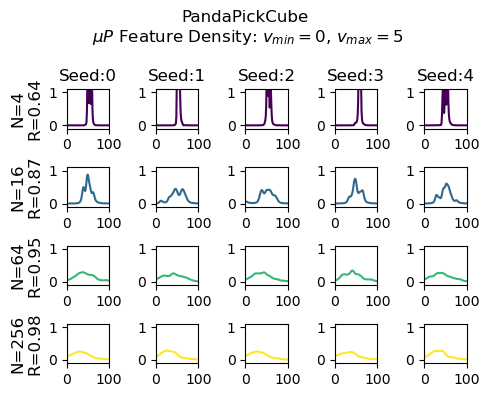

In [10]:
# get individual colors from viridis

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(N_to_plot)-1)) for i in range(len(N_to_plot))]

density_sim = np.zeros(len(N_to_plot))
f,ax = plt.subplots(len(N_to_plot),num_seeds, figsize=(1*num_seeds, 1*len(N_to_plot)))
f.suptitle(f"{env_name}\n {name} Feature Density: $v_{{min}}=0$, $v_{{max}}={vmax}$")
for i,N in enumerate(N_to_plot):
    n =  N_keys_corresponding_idxs[N]

    storeh = []
    for s in range(num_seeds):

        h = hdensity_loaded[scaling, n, s]
        ax[i,s].plot(h, color=colors[i])
        ax[0,s].set_title(f"Seed:{s}",fontsize=12)
        storeh.append(h.reshape(1,-1))
        ax[i,s].set_xlim([0, h.shape[0]])
        ax[i,s].set_ylim([-0.1, 1.1])
    
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    density_sim[i] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()
    ax[i, 0].set_ylabel(f"N={N}\nR={density_sim[i]:.2f}", fontsize=12)

f.tight_layout()

### Plot all 3 together

64 3
256 0
1024 1
64 2
256 0
1024 1
64 2
256 0
1024 1


/tmp/ipykernel_779408/1686908141.py:90: UserWarning: The figure layout has changed to tight
  f.tight_layout()


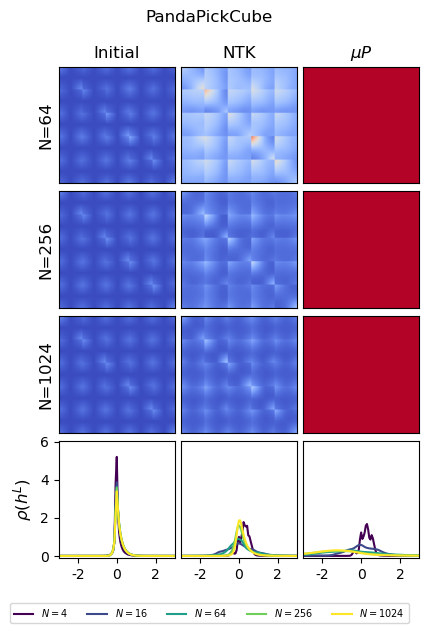

In [11]:
from matplotlib.lines import Line2D

# get individual colors from viridis

N_to_plot = [64, 256, 1024]
num_models = hdensity_loaded.shape[1]
colors = [cmap(i / (num_models-1)) for i in range(num_models)]
feat_sim = np.zeros(3)

f,ax = plt.subplots(len(N_to_plot)+1, 3, figsize=(1.5*3, 1.5*(len(N_to_plot)+1)),  constrained_layout=True)
f.suptitle(env_name)

for scaling in range(3):
    storeh = []

    # if scaling == 0:
    #     vmax = .5
    # elif scaling == 1:
    #     vmax = 0.5
    # else:
    #     vmax = 5
    
    if env_name == 'cartpole':
        vmax = 2
    elif env_name == 'panda':
        vmax = 1
    else:
        vmax = 1

    for key, feat in feature_layers_dict_loaded.items():
        if key not in N_to_plot:
            continue
        
        n =  N_keys_corresponding_idxs[key]

        print(key, i)

        i = N_to_plot.index(key)

        X = feat[scaling]
        K = np.einsum('ijk,ilk->ijl', X, X) / key

        K_mean = np.nanmean(K,axis=0)

        ax[i,scaling].imshow(K_mean[:65,:65], aspect='equal',cmap='coolwarm',vmin=0, vmax=vmax)

        storeh.append(h.reshape(1,-1))
        ax[i,scaling].set_xticks([])
        ax[i,scaling].set_yticks([])
        ax[i, 0].set_ylabel(f"N={key}", fontsize=12)

        # h = np.nanmean(hdensity_loaded[scaling, n],axis=0)
        # ax[-1,scaling].plot(h)
        # ax[-1,0].set_ylabel(f"$\\rho(h^L)$", fontsize=12)           
   
    ax[0,scaling].set_title(name_list[scaling],fontsize=12)
    storeh = np.concatenate(storeh, axis=0)
    tri_vals = np.corrcoef(storeh)
    feat_sim[scaling] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()


for scaling in range(3):

    for n in range(num_models):

        h = np.nanmean(hdensity_loaded[scaling, n],axis=0)
        if np.sum(h) == 0:
            continue
        N = list(N_keys_corresponding_idxs.keys())[n]

        ax[-1,scaling].plot(h, color=colors[n], label=f'$N={N}$')
        ax[-1,scaling].set_xlim([0, h.shape[0]])
        ax[-1,scaling].set_ylim([-0.1, hdensity_loaded.max()])
        # # Plot a box around the MAE region
        # ax[-1,scaling].axvspan(timestep_idx-1, timestep_idx+1, color='red', alpha=0.2)
        # ax[-1,scaling].set_aspect('equal')
        ax[-1,scaling].set_box_aspect(1)  # Only in matplotlib >= 3.4
        # ax[-1,scaling].set_xticks([])  # Hide x-axis ticks for top row
        if scaling != 0:
            ax[-1,scaling].set_yticks([])
        ax[-1,scaling].set_xticks(np.linspace(0,100,7)[1::2], np.linspace(-3,3,7,dtype=int)[1::2])

    ax[-1,0].set_ylabel(f"$\\rho(h^L)$", fontsize=12)         
    # Add legend box at the bottom of the figure

    if scaling == 0:
        f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=num_models, fontsize=7, frameon=True)


f.tight_layout()
f.subplots_adjust(wspace=0.05, hspace=0.05)
f.savefig(f"{fig_dir}/kernels_density_{env_name}.pdf",bbox_inches='tight')

### CKA within seeds and across width

In [ ]:
from scipy.spatial import procrustes
from numpy.linalg import norm

import torch

def center_kernel(K):
    n = K.shape[0]
    device = K.device
    eye = torch.eye(n, device=device)
    ones = torch.ones((n, n), device=device) / n
    H = eye - ones
    return H @ K @ H

def kernel_CKA_torch(X, Y, kernel_fn=None):
    """
    Computes CKA between two matrices using a kernel function.
    Both X and Y: (n_samples, n_features).
    Optionally pass a kernel_fn (default: linear kernel).
    Assumes inputs are torch tensors on CPU or GPU.
    """
    if kernel_fn is None:
        # Linear kernel by default
        Kx = X @ X.t()
        Ky = Y @ Y.t()
    else:
        Kx = kernel_fn(X)
        Ky = kernel_fn(Y)
    Kx_c = center_kernel(Kx)
    Ky_c = center_kernel(Ky)
    numerator = torch.sum(Kx_c * Ky_c)
    denominator = torch.sqrt(torch.sum(Kx_c ** 2) * torch.sum(Ky_c ** 2))
    return numerator / denominator

# Example of using RBF kernel
def rbf_kernel(X, gamma=None):
    # X: (n_samples, n_features)
    # Returns: (n_samples, n_samples)
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    dist_sq = torch.cdist(X, X, p=2) ** 2
    return torch.exp(-gamma * dist_sq)

def centered_kernel_alignment(X, Y):
    """
    Computes centered kernel alignment between two matrices.
    Both matrices are expected to be of shape (n_samples, n_features).
    """
    def center_kernel(K):
        n = K.shape[0]
        H = np.eye(n) - np.ones((n, n))/n
        return H @ K @ H
    
    Kx = X @ X.T
    Ky = Y @ Y.T
    Kx_c = center_kernel(Kx)
    Ky_c = center_kernel(Ky)
    numerator = np.sum(Kx_c * Ky_c)
    denominator = np.sqrt(np.sum(Kx_c ** 2) * np.sum(Ky_c ** 2))
    return numerator / denominator

def procrustes_alignment(X, Y):
    """
    Performs Procrustes analysis and returns the similarity.
    Matrices should be of the same shape (n_samples, n_features).
    """
    # scipy's procrustes aligns the shapes, returning mtx1, mtx2, disparity
    _, _, disparity = procrustes(X, Y)
    # Similarity can be defined as 1 - disparity (lower disparity = higher similarity)
    return 1 - disparity

def cosine_similarity_matrix(A, B):
    """
    Computes cosine similarity between two matrices (flattened).
    """
    a_flat = A.flatten()
    b_flat = B.flatten()
    return np.dot(a_flat, b_flat) / (norm(a_flat) * norm(b_flat))

def linear_CKA_fast(X, Y):
    """
    Efficient linear CKA between (n_samples, n_features) matrices X and Y.
    No kernel matrices constructed.
    """
    X = X - X.mean(axis=0, keepdims=True)
    Y = Y - Y.mean(axis=0, keepdims=True)
    numerator = np.sum(np.dot(X.T, Y) ** 2)
    denominator = np.sqrt(
        np.sum(np.dot(X.T, X) ** 2) * np.sum(np.dot(Y.T, Y) ** 2)
    )
    return numerator / denominator

def downsample_block_mean(matrix, new_shape):
    m, n = matrix.shape
    m_new, n_new = new_shape
    block_m = m // m_new
    block_n = n // n_new
    downsampled = matrix.reshape(m_new, block_m, n_new, block_n).mean(axis=(1, 3))
    return downsampled

In [ ]:
# CKA analysis within seeds and across width
across_width = np.zeros((3, len(layer_sizes), len(layer_sizes)))
within_seed = np.zeros((3,len(layer_sizes), num_seeds, num_seeds))
across_scales = np.zeros((len(layer_sizes), 3, 3))

samples = feat.shape[2]
print(samples)
Ks = np.zeros([3, len(layer_sizes), num_seeds, samples, samples])
for scaling in range(3):
    print(f"Scaling: {scaling}")


    for N, feat in feature_layers_dict_loaded.items():
        if np.sum(feat) == 0:
            continue
        H = feat[scaling]
        K = np.einsum('ijk,imn->ijm', H, H) / N # shape (num_seeds, num_points, num_points)

        n = layer_sizes.index(N)
        Ks[scaling, n] = K
        Ks[scaling, n] = np.nanmean(K, axis=0)
        
        for i in range(num_seeds):
            for j in range(num_seeds):
                if i < j:
                    within_seed[scaling, n, i, j] = centered_kernel_alignment(K[i], K[j])

    for i, N2 in enumerate(layer_sizes):
        for j, N3 in enumerate(layer_sizes):
            if i < j:
                across_width[scaling, i, j] = centered_kernel_alignment(Ks.mean(axis=0)[scaling, i], Ks.mean(axis=0)[scaling, j])

for i in range(3):
    for j in range(3):
        if i < j:
            for n, N in enumerate(layer_sizes):
                across_scales[n, i, j] = centered_kernel_alignment(Ks.mean(axis=0)[i, n], Ks.mean(axis=0)[j, n])


In [ ]:
# get the mean of the lower triangular value of the matrix
within_seed_mean = np.zeros((3, len(layer_sizes)))
for scaling in range(3):
    for n in range(len(layer_sizes)):
        tri_vals = within_seed[scaling, n]
        within_seed_mean[scaling, n] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()

across_width_mean = np.zeros(3)
for scaling in range(3):
    tri_vals = across_width[scaling]
    across_width_mean[scaling] = tri_vals[np.triu_indices_from(tri_vals, k=1)].mean()

across_scales_simple = np.zeros((len(layer_sizes),3))
for n in range(len(layer_sizes)):
    tri_vals = across_scales[n]
    across_scales_simple[n] = tri_vals[np.triu_indices_from(tri_vals, k=1)]

print("Within seed CKA mean:", within_seed_mean)
print("Across width CKA mean:", across_width_mean)

# generate unique string combinations using name_list
combinations = {}
for i in range(3):
    for j in range(i+1, 3):
        combinations[f"{name_list[i]} vs {name_list[j]}"] = across_scales[:, i, j]
        print(f"{name_list[i]} vs {name_list[j]}: {across_scales[:, i, j]}")


Within seed CKA mean: [[0.21306171 0.53357555 0.81459608 0.94479609 0.98060559]
 [0.08375261 0.1268109  0.7979624  0.73818658 0.95481389]
 [0.14198884 0.15827215 0.49109388 0.8447916  0.86829616]]
Across width CKA mean: [0.82252245 0.44950102 0.44278546]
Initial vs NTK: [0.34658914 0.27965181 0.455842   0.71806095 0.65859138]
Initial vs $\mu P$: [0.34602947 0.07504144 0.31467975 0.27123773 0.24001456]
NTK vs $\mu P$: [0.99966539 0.54236169 0.75191093 0.77922157 0.76777209]


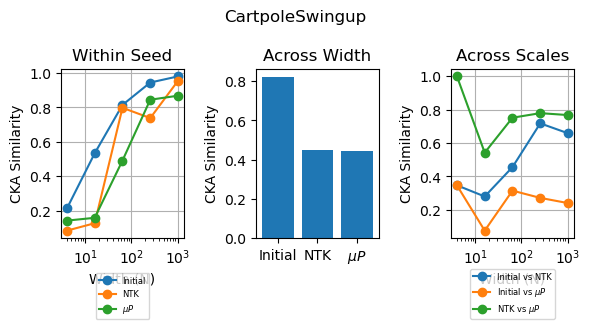

In [ ]:
plt.figure(figsize=(6,3))
plt.suptitle(env_name)
plt.subplot(131)
for scaling in range(3):
    plt.plot(layer_sizes, within_seed_mean[scaling], label=name_list[scaling], marker='o')
plt.xscale('log')
plt.xlabel('Width (N)')
plt.ylabel('CKA Similarity')
plt.title(f'Within Seed')
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=1)
plt.grid(True)

plt.subplot(132)
plt.bar(name_list, across_width_mean)
plt.ylabel('CKA Similarity')
plt.title(f'Across Width')
plt.tight_layout()

plt.subplot(133)
for key,value in combinations.items():
    plt.plot(layer_sizes, value, label=key, marker='o')
plt.xscale('log')
plt.xlabel('Width (N)')
plt.ylabel('CKA Similarity')
plt.title(f'Across Scales')
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=1)
plt.grid(True)
plt.tight_layout()

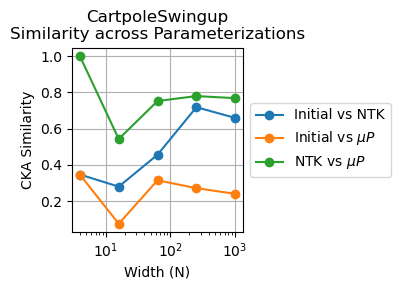

In [ ]:
plt.figure(figsize=(4,3))
for key,value in combinations.items():
    plt.plot(layer_sizes, value, label=key, marker='o')
plt.xscale('log')
plt.xlabel('Width (N)')
plt.ylabel('CKA Similarity')
plt.title(f'{env_name}\nSimilarity across Parameterizations')
plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{fig_dir}/cka_feature_summary_{env_name}.pdf",bbox_inches='tight')

### plot eigenspectrum

In [ ]:
# perform eigenspectrum decomposition of 2D matrix

topk = 3
cum_spectrum = np.zeros([3, len(layer_sizes), num_seeds, topk])

for scaling in range(3):
    for n in range(len(layer_sizes)):
        if np.sum(Ks[scaling, n]) == 0:
            continue

        for s in range(num_seeds):
            if np.sum(Ks[scaling, n, s]) == 0:
                continue

            K = Ks[scaling, n, s]
            eigenvalues, eigenvectors = np.linalg.eigh(K)

            # Sort eigenvalues and eigenvectors in descending order
            sorted_indices = np.argsort(eigenvalues)[::-1]
            sorted_eigenvalues = eigenvalues[sorted_indices]
            sorted_eigenvectors = eigenvectors[:, sorted_indices]
            cum_spectrum[scaling, n, s] = np.cumsum(sorted_eigenvalues[:topk]) / np.sum(sorted_eigenvalues)
    


In [ ]:
# plot the cumulative spectrum vs width
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(6,4))
for scaling in range(3):
    lambda1 = cum_spectrum[scaling].sum(axis=2)
    mean = lambda1.mean(axis=1)
    std = lambda1.std(axis=1) / np.sqrt(num_seeds)
    plt.plot(layer_sizes, mean, label=name_list[scaling], color=colors[scaling])
    plt.fill_between(layer_sizes, mean - std, mean + std, alpha=0.2, color=colors[scaling])
plt.xscale('log')
plt.ylim([0,1])
plt.xlabel('Width (N)')
plt.ylabel('Cumulative Spectrum')
plt.title(f'{env_name}: Top k={topk}')
# plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{fig_dir}/eigenspectrum_feature_summary_{env_name}.pdf",bbox_inches='tight')
